## Import des packages

In [1]:
from product_sub.infrastructure.dataset_builder import DatasetBuilder
from product_sub.domain.pipeline_creator import PipelineCreator
import product_sub.settings as stg

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, plot_confusion_matrix
from sklearn.metrics import classification_report
 
from sklearn.svm import SVC


from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import NearMiss

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Import des données et pipelines

In [2]:
dataset_merged = DatasetBuilder(
    filename_bank=stg.FILENAME_BANK, filename_socio=stg.FILENAME_SOCIO_ECO
).create_dataset()
X = dataset_merged.drop(columns=stg.COL_RAW_SUBSCRIPTION)
y = dataset_merged[stg.COL_RAW_SUBSCRIPTION].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=stg.RANDOM_STATE
)

custom_pipeline_accessor = PipelineCreator()
preprocessor = custom_pipeline_accessor.preprocessor

clf = Pipeline(steps=[ ('preprocessor' , preprocessor),
                           ('rf',  RandomForestClassifier()) ])
rf = RandomForestClassifier()
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## OverSampling

In [3]:
smt = SMOTE(sampling_strategy=1,random_state=stg.RANDOM_STATE)
X_resampled, y_resampled = smt.fit_resample(X_train, y_train)

In [46]:
smote_enn = SMOTEENN(sampling_strategy=1, random_state=0)
#X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

In [4]:
near_miss = NearMiss()
#X_resampled, y_resampled = near_miss.fit_resample(X_train, y_train)

In [19]:
grid_params_rf = [{
                'criterion': ['entropy'],
                'min_samples_leaf': [40,60, 80],
                'max_depth': [15,25,30],
                'min_samples_split': [3, 5, 10],
                'n_estimators' : [60, 70]
                }]
cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=stg.RANDOM_STATE)
search = GridSearchCV(rf, grid_params_rf, n_jobs=-1, refit=True)
search.fit(X_resampled, y_resampled)
y_train

array([1, 0, 0, ..., 0, 0, 0])

In [20]:
search.best_params_

{'criterion': 'entropy',
 'max_depth': 30,
 'min_samples_leaf': 40,
 'min_samples_split': 10,
 'n_estimators': 70}

## Exemple under & over avec SMOTEEIN

In [ ]:
##WITH SMOTE

#good_rf = RandomForestClassifier(criterion="entropy", max_depth=15, min_samples_leaf=40, min_samples_split=3, n_estimators=60)
#good_rf.fit(X_train, y_train)

##WITHOUT SMOTE
good_rf = RandomForestClassifier(criterion='entropy', max_depth=25, min_samples_leaf=40, min_samples_split=3, n_estimators=60)
good_rf.fit(X_train, y_train)

In [21]:
# WITH UNDER&OVER
good_rf = RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_leaf=40, min_samples_split=10, n_estimators=70)
good_rf.fit(X_resampled, y_resampled)

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_leaf=40,
                       min_samples_split=10, n_estimators=70)

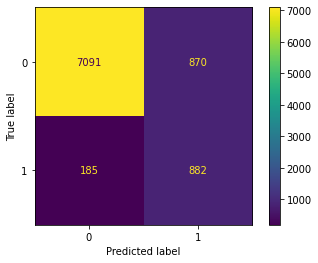

In [22]:
plot_confusion_matrix(good_rf,X_test, y_test)

In [4]:
r=[0.1,1,10]
pg_svm=[{'C':r, 'kernel':['linear']}]
#        {'C':r, 'gamma':r, 'kernel':['rbf']}]
svm = SVC(random_state=stg.RANDOM_STATE)

cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=stg.RANDOM_STATE)
gs_svm=GridSearchCV(estimator= svm,
               param_grid= pg_svm,
                refit=True,
                n_jobs=-1,
               cv=2)
gs_svm.fit(X_resampled, y_resampled)

GridSearchCV(cv=2, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid=[{'C': [0.1, 1, 10], 'kernel': ['linear']}])

# SVM

In [5]:
y_true, y_pred = y_test, gs_svm.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.84      0.91      7961
           1       0.42      0.86      0.57      1067

    accuracy                           0.84      9028
   macro avg       0.70      0.85      0.74      9028
weighted avg       0.91      0.84      0.87      9028



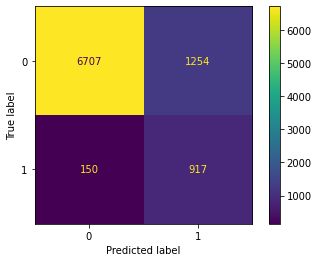

In [6]:
plot_confusion_matrix(gs_svm,X_test, y_test)

# RANDOM FOREST

In [ ]:
y_true, y_pred = y_test, search.predict(X_test)
print(classification_report(y_true, y_pred))

# LOGREG

In [7]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
log_reg = LogisticRegression()
cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=stg.RANDOM_STATE)
logreg_cv=GridSearchCV(estimator= log_reg,
               param_grid= grid,
               scoring='recall',
                refit=True,
                n_jobs=-1,
               cv=cv)
logreg_cv.fit(X_resampled, y_resampled)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             scoring='recall')

In [8]:
y_true, y_pred = y_test, logreg_cv.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7961
           1       0.43      0.84      0.57      1067

    accuracy                           0.85      9028
   macro avg       0.70      0.84      0.74      9028
weighted avg       0.91      0.85      0.87      9028



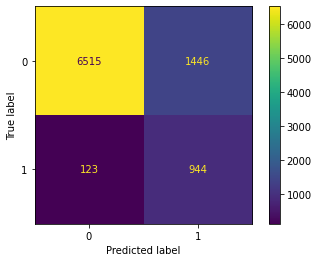

In [35]:
plot_confusion_matrix(logreg_cv,X_test, y_test)

# GRADIENT BOOSTING

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
grid = {
    "loss":["deviance"],
    "learning_rate": [0.2, 0.15],
    "min_samples_split": np.linspace(0.1, 0.5, 2),
    "min_samples_leaf": np.linspace(0.1, 0.5, 2),
    "max_depth":[3,5,8 ],
    "criterion": ["friedman_mse"],
    "subsample":[1],
    "n_estimators":[10]
    }
gbc = GradientBoostingClassifier()
cv = StratifiedKFold(shuffle=True, n_splits=3, random_state=stg.RANDOM_STATE)
gboost_cv=GridSearchCV(estimator= gbc,
               param_grid= grid,
                refit=True,
                n_jobs=-1,
               cv=cv, verbose=True)
gboost_cv.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   10.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'criterion': ['friedman_mse'],
                         'learning_rate': [0.2, 0.15], 'loss': ['deviance'],
                         'max_depth': [3, 5, 8],
                         'min_samples_leaf': array([0.1, 0.5]),
                         'min_samples_split': array([0.1, 0.5]),
                         'n_estimators': [10], 'subsample': [1]},
             verbose=True)

In [ ]:
gboost_cv.best_params_

In [10]:
y_true, y_pred = y_test, gboost_cv.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7961
           1       0.44      0.86      0.58      1067

    accuracy                           0.85      9028
   macro avg       0.71      0.86      0.75      9028
weighted avg       0.92      0.85      0.87      9028



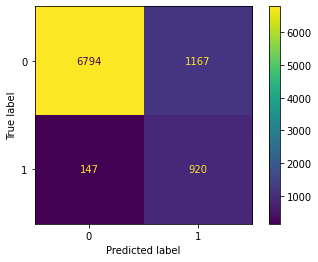

In [11]:
plot_confusion_matrix(gboost_cv,X_test, y_test)

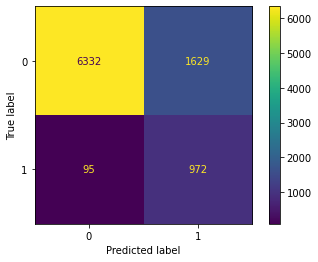

In [49]:
plot_confusion_matrix(gboost_cv,X_test, y_test)

## KNN

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm
#Setup arrays to store training and test accuracies
neighbors = np.arange(1, 6)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in tqdm(enumerate(neighbors)):
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_resampled, y_resampled)
    train_accuracy[i] = knn.score(X_resampled, y_resampled)
    test_accuracy[i] = knn.score(X_test, y_test) 



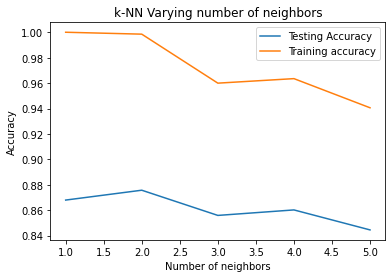

In [14]:
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()


In [15]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_resampled,y_resampled)
knn.score(X_test,y_test)

0.8757199822773594

In [16]:
y_pred = knn.predict(X_test)
y_true, y_pred = y_test, knn.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7961
           1       0.48      0.54      0.51      1067

    accuracy                           0.88      9028
   macro avg       0.71      0.73      0.72      9028
weighted avg       0.88      0.88      0.88      9028



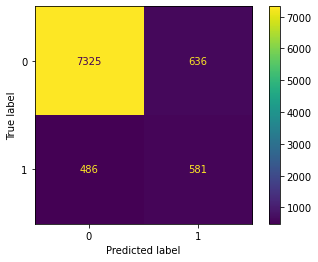

In [17]:
plot_confusion_matrix(knn,X_test, y_test)